## Online Factorization Machine 
Online factorization models take single data as an input, make a prediction, and train with the data.

### 1. Setup
The from models imports the package for use. We have also imported a few other packages for plotting.

In [1]:
import sys
sys.path.append('./../')

from utils import data_preprocess, plot
import os
import pickle
import numpy as np
import torch

from time import time

from models.models_online.FM_FTRL import FM_FTRL
from models.models_online.SFTRL_CCFM import SFTRL_CCFM
from models.models_online.SFTRL_Vanila import SFTRL_Vanila
from models.models_online.RRF_Online import RRF_Online
from utils.data_manager  import *
from utils.metric_manager import *

Tensor_type = torch.DoubleTensor



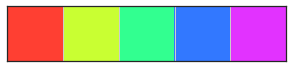

In [9]:
import seaborn as sns
import os
sns.set()
sns.set_style('white')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')

current_palette = sns.color_palette(sns.hls_palette(5, l=.6, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

### 2. Create a dataset depending on task
We prepare movielens100-k for regression and cod-ran dataset for classification

In [11]:
task = 'cls'

In [12]:
if task == 'reg':
    nbUsers = 943
    nbMovies = 1682
    nbFeatures = nbUsers + nbMovies
    nbRatingsTrain = 90570
    nbRatingsTest = 9430
    data_dir = os.getcwd() + '/../dataset/ml-100k/'

    #filename1, filename2 = 'ub.base', 'ub.test'
    filename1, filename2 = 'ua.base', 'ua.test'
    _, x_train, y_train, rate_train, timestamp_train = load_dataset_movielens(data_dir + filename1,nbRatingsTrain,nbFeatures,nbUsers)
    x_train_s, rate_train_s, _ = sort_dataset_movielens(x_train, rate_train, timestamp_train)
    want_permute = True
    if want_permute :
        idx = np.random.permutation(x_train_s.shape[0])
        x_train_s = x_train_s[idx]
        rate_train_s = rate_train_s[idx]
    else:
        pass
    x_train_s = x_train_s.todense()

    
    
elif task == 'cls':
    data_dir = './../dataset/cod-rna2/'
    filename = "cod-rna2.scale"
    X, y = load_svmlight_file(data_dir + filename, n_features=8)
    X = X.toarray()

    want_permute = False
    if want_permute :
        idx = np.random.permutation(X.shape[0])
        x_train_s = np.asarray(X[idx])
        rate_train_s = np.asarray(y[idx])
    else:
        x_train_s = np.asarray(X)
        rate_train_s = np.asarray(y)

else:
    raise ValueError

### 3. Create factorization machines and conduct online task
There are four models in this notebook; 'FTRL','SFTRL_C','SFTRL_V','Online_RFF'

In [13]:
model_option_list = ['FTRL','SFTRL_C','SFTRL_V','Online_RFF']

In [18]:
model_option = 'SFTRL_C'
#model_option = 'Online_RFF'

m = 40
lr_FM = 0.005

In [19]:
assert(model_option in model_option_list)
if model_option is 'FTRL':
    Model_FM_FTRL = FM_FTRL(Tensor_type(x_train_s),Tensor_type(rate_train_s) , task,lr_FM, m )
    pred_y, label_y , time = Model_FM_FTRL.online_learning()

elif model_option is 'SFTRL_C':
    Model_SFTRL_C = SFTRL_CCFM(Tensor_type(x_train_s),Tensor_type(rate_train_s) , task,lr_FM,m )
    pred_y, label_y , time = Model_SFTRL_C.online_learning()

elif model_option is 'SFTRL_V':
    Model_SFTRL_V = SFTRL_Vanila(Tensor_type(x_train_s),Tensor_type(rate_train_s) , task,lr_FM,m )
    pred_y, label_y , time = Model_SFTRL_V.online_learning()

elif model_option in 'Online_RFF':
    inputs_matrix, outputs = Tensor_type(x_train_s), Tensor_type(rate_train_s)
    Online_RRF = RRF_Online(inputs_matrix,outputs,task)
    pred_y, label_y , time = Online_RRF.online_learning()

    #print(type(x_train_s))
    

SFTRL_CCFM_0.005_40_start
 0 th : pred 1.000000 , real -1.000000 
 1000 th : pred -1.000000 , real -1.000000 
 2000 th : pred -1.000000 , real 1.000000 
 3000 th : pred -1.000000 , real -1.000000 
 4000 th : pred -1.000000 , real -1.000000 
 5000 th : pred -1.000000 , real -1.000000 
 6000 th : pred -1.000000 , real -1.000000 
 7000 th : pred -1.000000 , real -1.000000 
 8000 th : pred -1.000000 , real -1.000000 
 9000 th : pred -1.000000 , real -1.000000 
 10000 th : pred -1.000000 , real -1.000000 
 11000 th : pred -1.000000 , real -1.000000 
 12000 th : pred -1.000000 , real -1.000000 
 13000 th : pred -1.000000 , real -1.000000 
 14000 th : pred -1.000000 , real -1.000000 
 15000 th : pred -1.000000 , real -1.000000 
 16000 th : pred -1.000000 , real -1.000000 
 17000 th : pred -1.000000 , real -1.000000 
 18000 th : pred -1.000000 , real -1.000000 
 19000 th : pred -1.000000 , real -1.000000 
 20000 th : pred -1.000000 , real -1.000000 
 21000 th : pred -1.000000 , real -1.000000 

### 4. Cacluate Metric
We prepare the each metric for regression (average root mean squre) and classification (average accuracy )

In [20]:
if task == 'reg':
    metric = regression_metric(pred_y,label_y)    
elif task == 'cls':
    _,metric = classfication_metric(pred_y,label_y)

### 5. Results figures
We shows the resutls of prediction and accuracy for regression and classification

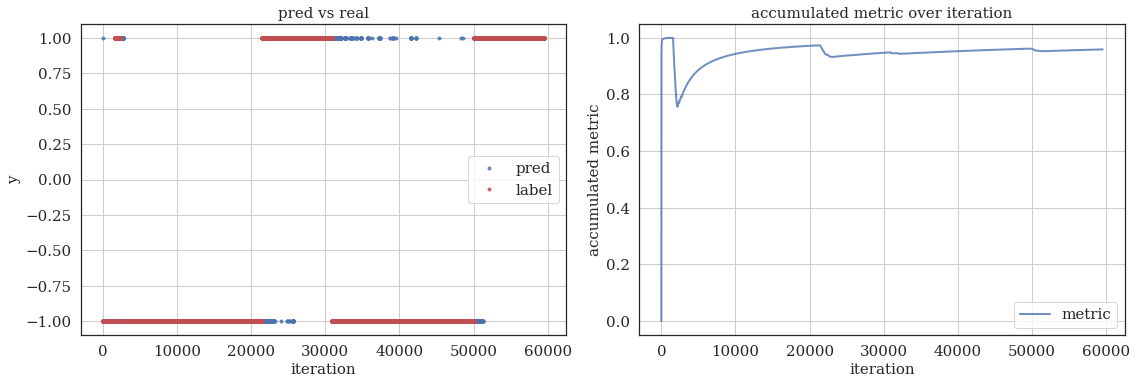

In [21]:
fontsiz = 15

fig = plt.figure(figsize=(8*2,5.5))
fig.add_subplot(1,2,1)
plt.plot(pred_y,'b.', label = 'pred',alpha = 0.8)
plt.plot(label_y,'r.' , label = 'label',alpha = 0.8)
plt.xlabel('iteration' , fontsize = fontsiz)
plt.ylabel('y' , fontsize = fontsiz)
plt.title('pred vs real' ,fontsize = fontsiz)
plt.tick_params(axis='both', labelsize=fontsiz)
#plt.legend(loc='upper center', bbox_to_anchor=(0, 1. + 0.075 ,1-0.05,0.1), ncol = 2 , fontsize = fontsiz)
plt.legend( fontsize = fontsiz)

fig.add_subplot(1,2,2)
plt.plot(metric,'b', label = 'metric',alpha = 0.8 ,linewidth = 2.0)
plt.xlabel('iteration' , fontsize = fontsiz)
plt.ylabel('accumulated metric' , fontsize = fontsiz)
plt.title('accumulated metric over iteration' ,fontsize = fontsiz)
plt.tick_params(axis='both', labelsize=fontsiz)
#plt.legend(ncol = 2 , fontsize = 12)
#plt.legend(loc='upper center', bbox_to_anchor=(0, 1. + 0.075 ,1-0.05,0.1), ncol = 2 , fontsize = fontsiz)
plt.legend( fontsize = fontsiz)
fig.tight_layout()    

